# Diabetes Readmission Prediction: Implementation Details

This notebook documents the full implementation that powers the 30-day readmission prediction project and captures a few exploratory extensions. We'll walk through:

1. Data Loading and Preprocessing
2. Model Implementations:
   - Logistic Regression (production pipeline)
   - Random Forest (optional experiment)
   - XGBoost (optional experiment; requires extra install)
3. Visualizations
4. Cost Analysis

## Project Goals
- Identify high-risk patients (Zone of Danger)
- Improve patient outcomes
- Reduce readmission rates
- Save operational costs
- Avoid CMS HRRP penalties

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add project root to path
# When running in Jupyter, get the notebook's directory and go up one level
import os
notebook_dir = Path(os.getcwd())
# If we're in notebooks/, go up one level; otherwise assume we're at project root
if notebook_dir.name == 'notebooks':
    PROJECT_ROOT = notebook_dir.parent
else:
    PROJECT_ROOT = notebook_dir

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Our project modules
from src.config import Config
from src.preprocess import basic_clean, train_test_split_clean
from src.model import build_pipeline

# Helper functions (replacing data_prep functions)
def get_feature_columns(df):
    """Identify numeric and categorical columns"""
    numeric_cols = []
    categorical_cols = []
    
    for col in df.columns:
        if col in ['encounter_id', 'patient_nbr', 'readmitted', 'readmitted_binary']:
            continue
        try:
            pd.to_numeric(df[col], errors='raise')
            numeric_cols.append(col)
        except (ValueError, TypeError):
            categorical_cols.append(col)
    
    return numeric_cols, categorical_cols

def age_to_ordinal(age_series):
    """Convert age brackets to ordinal values"""
    age_map = {
        '[0-10)': 1, '[10-20)': 2, '[20-30)': 3, '[30-40)': 4,
        '[40-50)': 5, '[50-60)': 6, '[60-70)': 7, '[70-80)': 8,
        '[80-90)': 9, '[90-100)': 10
    }
    return age_series.map(age_map).fillna(0)

# Configuration
config = Config()
DIABETIC_CSV = config.resolved_raw_path()
PROCESSED_DIR = config.processed_train_path().parent
MODELS_DIR = config.models_path()
RANDOM_SEED = config.random_state

# Set style for plots
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('seaborn')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


# 1. Data Loading and Feature Analysis

Let's start by loading our dataset and examining its features. We'll look at:
- Basic statistics
- Missing values
- Feature distributions
- Target variable distribution

In [2]:
# Load the dataset
if not DIABETIC_CSV.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DIABETIC_CSV}. Please place 'diabetic_data.csv' under data/raw/."
    )

df = pd.read_csv(DIABETIC_CSV, dtype=str, low_memory=False)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

# Get feature columns
num_cols, cat_cols = get_feature_columns(df)
print("\nNumeric Features:", num_cols[:10], "...")  # Show first 10
print(f"Total numeric features: {len(num_cols)}")
print("\nCategorical Features:", cat_cols[:10], "...")  # Show first 10
print(f"Total categorical features: {len(cat_cols)}")

# Create binary target
df["readmitted_binary"] = (df["readmitted"] == "<30").astype(int)

# Basic target distribution
print("\nTarget Distribution:")
print(df["readmitted_binary"].value_counts(normalize=True))

Dataset Shape: (101766, 50)

First few rows:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO



Numeric Features: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient'] ...
Total numeric features: 11

Categorical Features: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum'] ...
Total categorical features: 36

Target Distribution:
readmitted_binary
0    0.888401
1    0.111599
Name: proportion, dtype: float64


# 2. Required Visualizations

As specified in the project requirements, we'll create three key visualizations:
1. Average Length of Stay Analysis
2. Gender-based Readmission Rates
3. A1C Level vs Readmission Risk

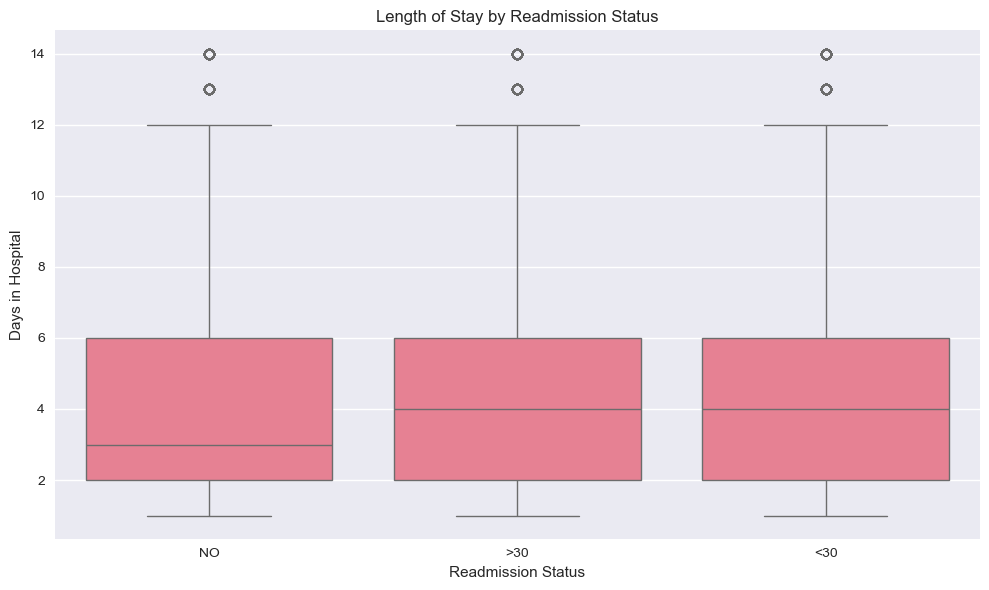


Average Length of Stay by Readmission Status:


,mean,std
readmitted,,
<30,4.77,3.03
>30,4.50,2.99
NO,4.25,2.96


<Figure size 1000x600 with 0 Axes>

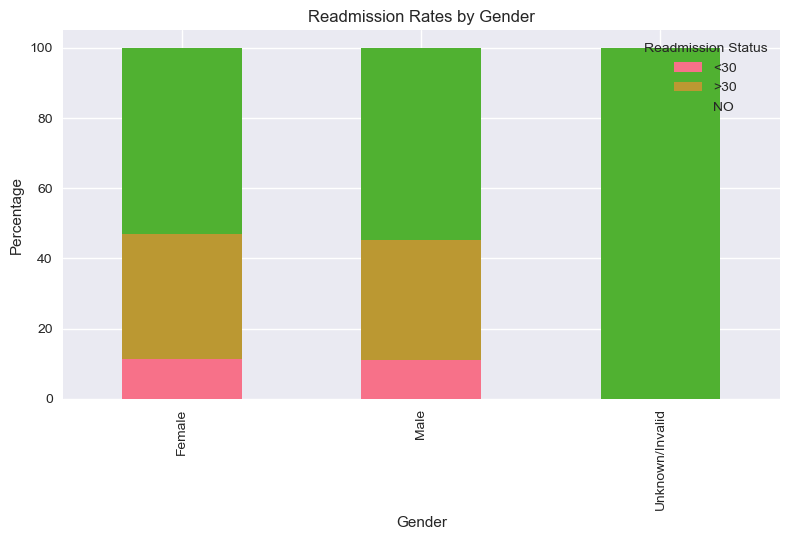


Readmission Rates by Gender:


readmitted,<30,>30,NO
gender,,,
Female,11.25,35.68,53.08
Male,11.06,34.06,54.88
Unknown/Invalid,0.00,0.00,100.00


<Figure size 1000x600 with 0 Axes>

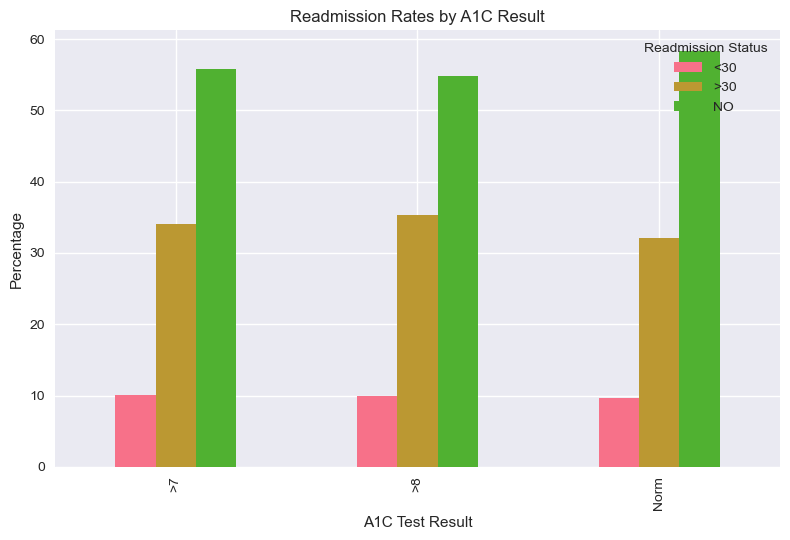


Readmission Rates by A1C Result:


readmitted,<30,>30,NO
A1Cresult,,,
>7,10.05,34.10,55.85
>8,9.87,35.31,54.82
Norm,9.66,32.04,58.30


In [3]:
# 1. Average Length of Stay Analysis
plt.figure(figsize=(10, 6))
df['time_in_hospital'] = pd.to_numeric(df['time_in_hospital'], errors='coerce')
sns.boxplot(x='readmitted', y='time_in_hospital', data=df)
plt.title('Length of Stay by Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Days in Hospital')
plt.tight_layout()
plt.show()

# Calculate average stay by readmission status
avg_stay = df.groupby('readmitted')['time_in_hospital'].agg(['mean', 'std']).round(2)
print("\nAverage Length of Stay by Readmission Status:")
display(avg_stay)

# 2. Gender-based Readmission Rates
if 'gender' in df.columns:
    plt.figure(figsize=(10, 6))
    gender_readmit = pd.crosstab(df['gender'], df['readmitted'], normalize='index') * 100
    gender_readmit.plot(kind='bar', stacked=True)
    plt.title('Readmission Rates by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Percentage')
    plt.legend(title='Readmission Status')
    plt.tight_layout()
    plt.show()
    
    print("\nReadmission Rates by Gender:")
    display(gender_readmit.round(2))
else:
    print("Gender column not found in dataset")

# 3. A1C Level Analysis
if 'A1Cresult' in df.columns:
    plt.figure(figsize=(10, 6))
    a1c_readmit = pd.crosstab(df['A1Cresult'], df['readmitted'], normalize='index') * 100
    a1c_readmit.plot(kind='bar')
    plt.title('Readmission Rates by A1C Result')
    plt.xlabel('A1C Test Result')
    plt.ylabel('Percentage')
    plt.legend(title='Readmission Status')
    plt.tight_layout()
    plt.show()
    
    print("\nReadmission Rates by A1C Result:")
    display(a1c_readmit.round(2))
else:
    print("A1Cresult column not found in dataset")

# 3. Model Implementation Details

Let's look at our three models:
1. Logistic Regression (Baseline)
2. Random Forest (Advanced)
3. XGBoost (Improved Accuracy)

We'll examine each model's implementation, parameters, and performance.

In [4]:
# Prepare data for modeling
def prepare_data(df):
    df_work = df.copy()
    # Convert numeric columns
    for c in num_cols:
        if c in df_work.columns:
            df_work[c] = pd.to_numeric(df_work[c], errors='coerce')
    
    # Convert age if present
    if "age" in df_work.columns:
        df_work["age"] = age_to_ordinal(df_work["age"])
        if "age" in cat_cols and "age" not in num_cols:
            cat_cols.remove("age")
            num_cols.append("age")
    
    # Only use columns that exist
    available_num = [c for c in num_cols if c in df_work.columns]
    available_cat = [c for c in cat_cols if c in df_work.columns]
    
    X = df_work[available_num + available_cat].copy()
    y = df_work["readmitted_binary"].astype(int)
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

# Create preprocessing pipelines
def create_preprocessor():
    # Get current available columns
    available_num = [c for c in num_cols if c in df.columns]
    available_cat = [c for c in cat_cols if c in df.columns]
    
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
    ])
    
    try:
        one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        one_hot = OneHotEncoder(handle_unknown="ignore", sparse=False)

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", one_hot),
    ])
    
    transformers = []
    if available_num:
        transformers.append(("num", num_pipeline, available_num))
    if available_cat:
        transformers.append(("cat", cat_pipeline, available_cat))
    
    return ColumnTransformer(transformers, remainder="drop")

# Split data
X_train, X_test, y_train, y_test = prepare_data(df)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print(f"Number of features: {X_train.shape[1]}")

Training set shape: (81412, 47)
Testing set shape: (20354, 47)
Number of features: 47


In [5]:
# Create baseline train/test splits using the production helper
# Use train_test_split_clean which properly loads, cleans, and splits the data
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split_clean(config)

print("Baseline (production) split shapes:")
print(f"  Train: {X_train_base.shape} | Test: {X_test_base.shape}")
print("  Positive rate (train): {:.3f}".format(y_train_base.mean()))
print("  Positive rate (test):  {:.3f}".format(y_test_base.mean()))


Baseline (production) split shapes:
  Train: (81412, 41) | Test: (20354, 41)
  Positive rate (train): 0.112
  Positive rate (test):  0.112


## 3.1 Logistic Regression (Baseline)

This section mirrors the production training script by reusing `src.preprocess.basic_clean` and `src.model.build_pipeline`:
- Standardizes numeric features with `StandardScaler(with_mean=False)`
- One-hot encodes categorical columns while ignoring unseen values
- Fits `LogisticRegression(max_iter=1000)` with default class weighting
- Produces the same artifact as `python scripts/run_train.py`

Logistic Regression Results (production-aligned):

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79     18083
           1       0.17      0.52      0.26      2271

    accuracy                           0.67     20354
   macro avg       0.55      0.61      0.52     20354
weighted avg       0.84      0.67      0.73     20354


ROC AUC Score: 0.6458


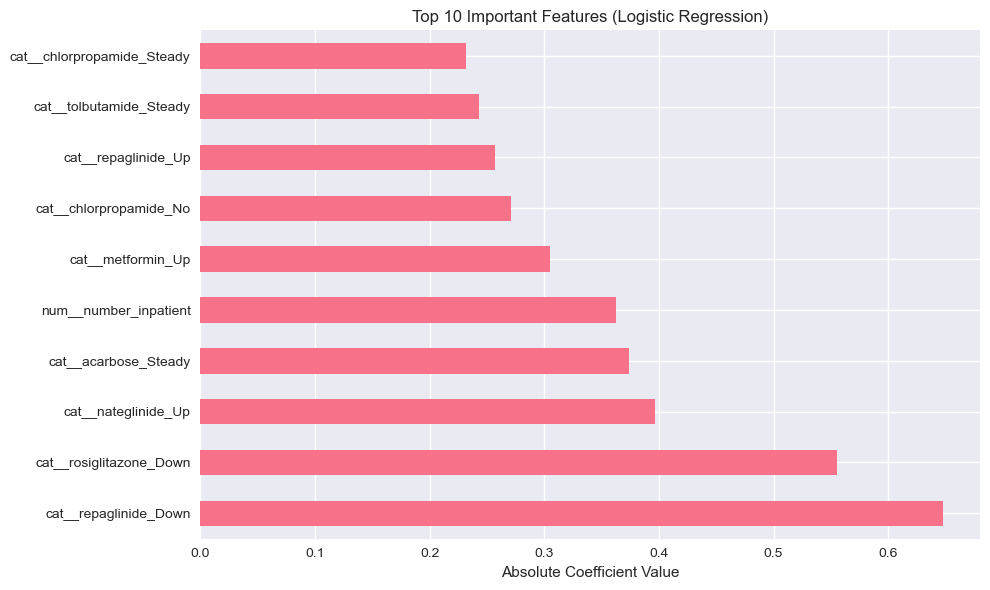

In [6]:
# Train and evaluate the production-aligned logistic regression pipeline
lr_pipeline = build_pipeline(X_train_base)

# Fit and evaluate
lr_pipeline.fit(X_train_base, y_train_base)
lr_pred = lr_pipeline.predict(X_test_base)

try:
    lr_proba = lr_pipeline.predict_proba(X_test_base)[:, 1]
except Exception:
    lr_proba = None

print("Logistic Regression Results (production-aligned):")
print("\nClassification Report:")
print(classification_report(y_test_base, lr_pred))
if lr_proba is not None:
    print(f"\nROC AUC Score: {roc_auc_score(y_test_base, lr_proba):.4f}")
else:
    print("\nROC AUC Score: not available (no predict_proba output)")

# Feature importance using model coefficients
try:
    # The pipeline step is named "preprocess" (not "pre")
    preprocessor = lr_pipeline.named_steps["preprocess"]
    if hasattr(preprocessor, "get_feature_names_out"):
        feature_names = preprocessor.get_feature_names_out().tolist()
    else:
        feature_names = [f"feature_{i}" for i in range(lr_pipeline.named_steps["clf"].coef_.shape[1])]

    coefficients = lr_pipeline.named_steps["clf"].coef_.flatten()
    if len(feature_names) != len(coefficients):
        feature_names = feature_names[:len(coefficients)]

    importance = pd.Series(coefficients, index=feature_names)

    plt.figure(figsize=(10, 6))
    importance.abs().nlargest(10).plot(kind="barh")
    plt.title("Top 10 Important Features (Logistic Regression)")
    plt.xlabel("Absolute Coefficient Value")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

## 3.2 Random Forest (Optional Experiment)

This optional variant layers additional preprocessing (median imputation + class weighting) on top of the baseline to explore whether tree ensembles boost recall:
- 100 trees (n_estimators=100)
- Maximum depth of 10 to prevent overfitting
- Minimum samples for split and leaf to reduce noise
- Balanced class weights for handling imbalance

Random Forest Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76     18083
           1       0.17      0.58      0.26      2271

    accuracy                           0.64     20354
   macro avg       0.55      0.61      0.51     20354
weighted avg       0.84      0.64      0.70     20354


ROC AUC Score: 0.6522


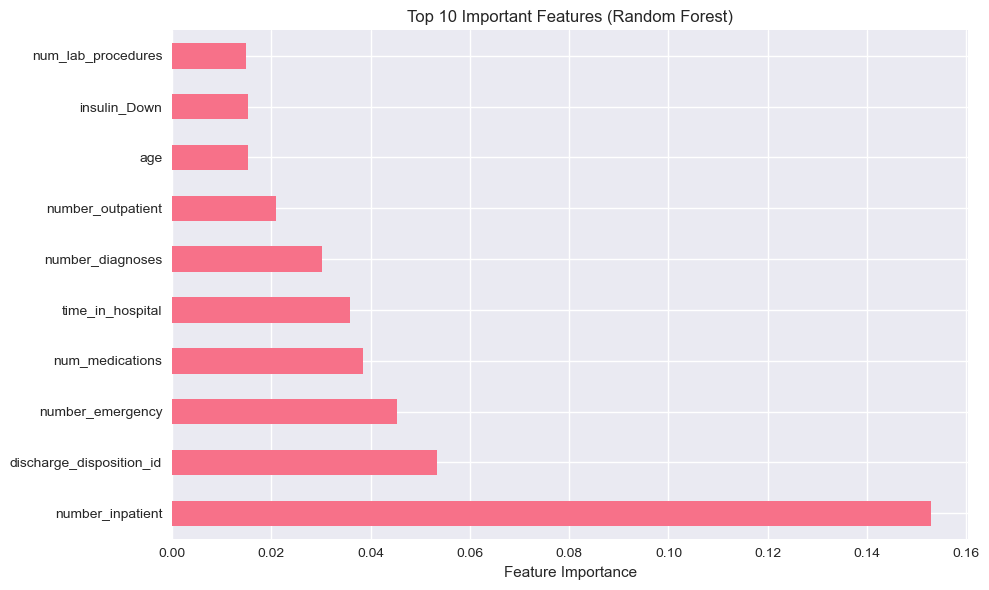

In [7]:
# Import and create Random Forest pipeline
from sklearn.ensemble import RandomForestClassifier

# Create pipeline
rf_pipeline = Pipeline([
    ("preproc", create_preprocessor()),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=RANDOM_SEED
    ))
])

# Fit and evaluate
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, rf_proba):.4f}")

# Get feature importance for Random Forest
try:
    # Get feature names from the preprocessor
    preproc = rf_pipeline.named_steps["preproc"]
    feature_names = []
    
    # Add numeric feature names
    if "num" in preproc.named_transformers_:
        available_num = [c for c in num_cols if c in df.columns]
        feature_names.extend(available_num)
    
    # Add categorical feature names
    if "cat" in preproc.named_transformers_:
        available_cat = [c for c in cat_cols if c in df.columns]
        try:
            cat_features = preproc.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(available_cat)
            feature_names.extend(cat_features.tolist())
        except AttributeError:
            # Fallback for older sklearn
            cat_features = preproc.named_transformers_["cat"].named_steps["onehot"].get_feature_names(available_cat)
            feature_names.extend(cat_features)
    
    # Plot top 10 features
    if len(feature_names) > 0:
        importances = pd.Series(
            rf_pipeline.named_steps["clf"].feature_importances_,
            index=feature_names[:len(rf_pipeline.named_steps["clf"].feature_importances_)]
        )
        
        plt.figure(figsize=(10, 6))
        importances.nlargest(10).plot(kind='barh')
        plt.title('Top 10 Important Features (Random Forest)')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print("Could not extract feature names")
except Exception as e:
    print(f"Could not plot feature importance: {e}")

## 3.3 XGBoost (Optional Experiment)

This experiment requires `xgboost` (install manually) and tests a gradient-boosted approach with:
- Learning rate of 0.1 for gradual improvement
- Maximum depth of 6 to control model complexity
- Early stopping to prevent overfitting
- Scale_pos_weight for imbalanced classes

Training XGBoost model...
XGBoost Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     18083
           1       0.18      0.59      0.28      2271

    accuracy                           0.66     20354
   macro avg       0.56      0.63      0.53     20354
weighted avg       0.85      0.66      0.72     20354


ROC AUC Score: 0.6821


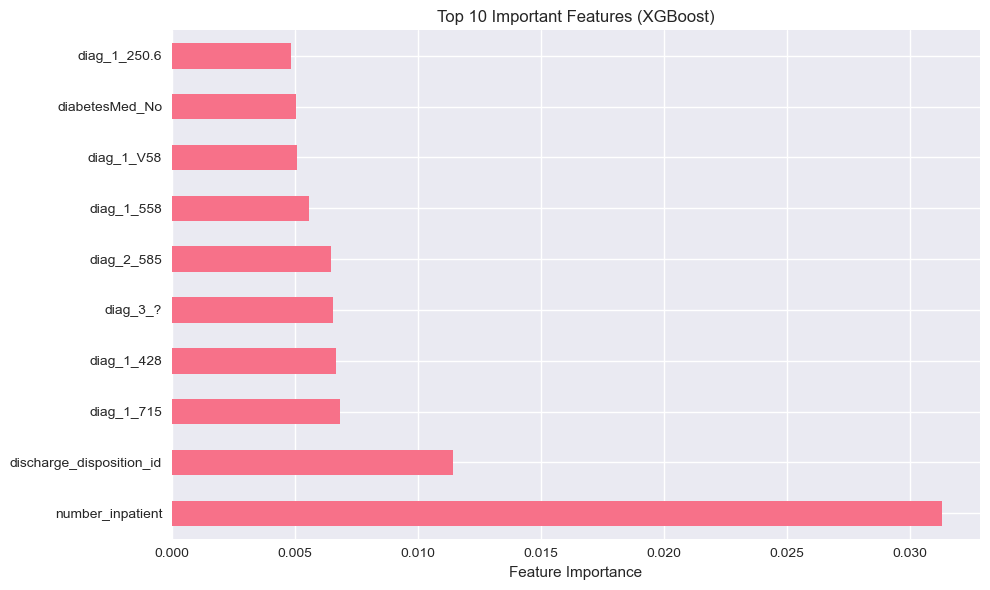

In [8]:
# Import and create XGBoost pipeline
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️ XGBoost is not installed. Please install it with:")
    print("   pip install xgboost")
    print("\nSkipping XGBoost model...")
    XGBOOST_AVAILABLE = False

if XGBOOST_AVAILABLE:
    # Calculate scale_pos_weight
    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Create pipeline
    xgb_pipeline = Pipeline([
        ("preproc", create_preprocessor()),
        ("clf", xgb.XGBClassifier(
            max_depth=6,
            learning_rate=0.1,
            n_estimators=100,
            scale_pos_weight=pos_weight,
            random_state=RANDOM_SEED
        ))
    ])
    
    # Fit and evaluate
    print("Training XGBoost model...")
    xgb_pipeline.fit(X_train, y_train)
    xgb_pred = xgb_pipeline.predict(X_test)
    xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]
    
    print("XGBoost Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, xgb_pred))
    print(f"\nROC AUC Score: {roc_auc_score(y_test, xgb_proba):.4f}")
    
    # Get feature importance for XGBoost
    try:
        # Get feature names from the preprocessor
        preproc = xgb_pipeline.named_steps["preproc"]
        feature_names = []
        
        # Add numeric feature names
        if "num" in preproc.named_transformers_:
            available_num = [c for c in num_cols if c in df.columns]
            feature_names.extend(available_num)
        
        # Add categorical feature names
        if "cat" in preproc.named_transformers_:
            available_cat = [c for c in cat_cols if c in df.columns]
            try:
                cat_features = preproc.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(available_cat)
                feature_names.extend(cat_features.tolist())
            except AttributeError:
                # Fallback for older sklearn
                cat_features = preproc.named_transformers_["cat"].named_steps["onehot"].get_feature_names(available_cat)
                feature_names.extend(cat_features)
        
        # Plot top 10 features
        if len(feature_names) > 0:
            importances = pd.Series(
                xgb_pipeline.named_steps["clf"].feature_importances_,
                index=feature_names[:len(xgb_pipeline.named_steps["clf"].feature_importances_)]
            )
            
            plt.figure(figsize=(10, 6))
            importances.nlargest(10).plot(kind='barh')
            plt.title('Top 10 Important Features (XGBoost)')
            plt.xlabel('Feature Importance')
            plt.tight_layout()
            plt.show()
        else:
            print("Could not extract feature names")
    except Exception as e:
        print(f"Could not plot feature importance: {e}")
else:
    print("\n💡 To install XGBoost, run: pip install xgboost")
    print("   Or install all requirements: pip install -r requirements.txt")

# 4. Cost Analysis

Based on the project requirements:
- Target: 1% reduction in readmissions
- Potential savings: $40,000-$60,000 per hospital
- Current CMS penalties: Up to 3% of Medicare reimbursements

Let's analyze the potential cost savings based on our model's performance.

Current 30-day readmission rate: 11.16%
Number of patients: 101,766
Current annual readmissions: 11357
With 1% reduction: 11243
Readmissions prevented: 114

Potential annual savings:
Minimum ($40,000 per case): $4,542,800.00
Maximum ($60,000 per case): $6,814,200.00


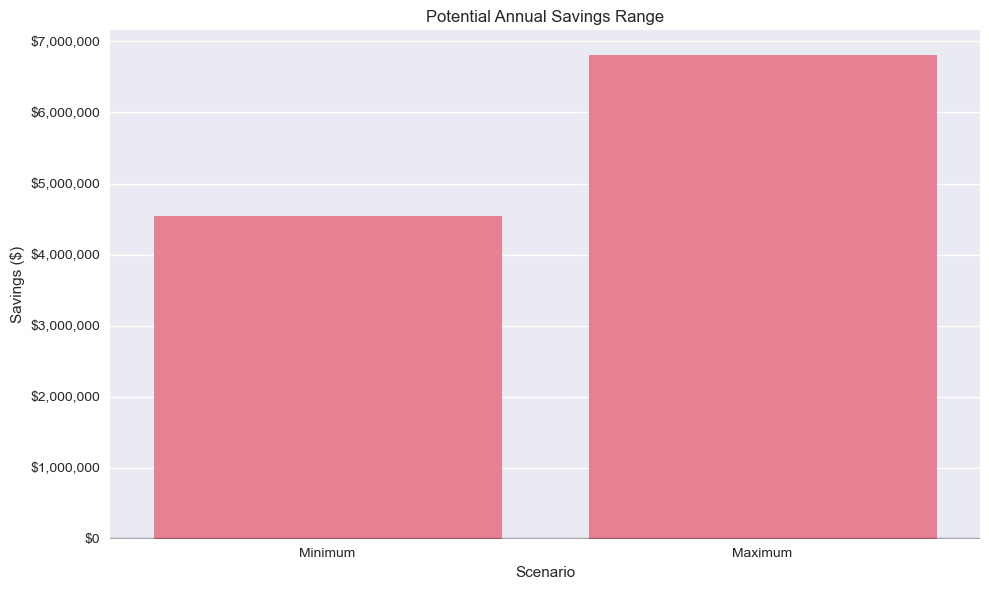

In [9]:
# Calculate potential savings
total_patients = len(df)
readmission_rate = (df['readmitted'] == '<30').mean()
current_readmissions = total_patients * readmission_rate

# Calculate 1% reduction
reduced_readmissions = current_readmissions * 0.99
readmissions_prevented = current_readmissions - reduced_readmissions

# Cost calculations
min_savings_per_case = 40000
max_savings_per_case = 60000

potential_savings_min = readmissions_prevented * min_savings_per_case
potential_savings_max = readmissions_prevented * max_savings_per_case

print(f"Current 30-day readmission rate: {readmission_rate:.2%}")
print(f"Number of patients: {total_patients:,}")
print(f"Current annual readmissions: {current_readmissions:.0f}")
print(f"With 1% reduction: {reduced_readmissions:.0f}")
print(f"Readmissions prevented: {readmissions_prevented:.0f}")
print(f"\nPotential annual savings:")
print(f"Minimum (${min_savings_per_case:,} per case): ${potential_savings_min:,.2f}")
print(f"Maximum (${max_savings_per_case:,} per case): ${potential_savings_max:,.2f}")

# Visualize savings potential
savings_data = pd.DataFrame({
    'Scenario': ['Minimum', 'Maximum'],
    'Savings': [potential_savings_min, potential_savings_max]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Scenario', y='Savings', data=savings_data)
plt.title('Potential Annual Savings Range')
plt.ylabel('Savings ($)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Format y-axis labels as currency
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: '${:,.0f}'.format(x)))

plt.tight_layout()
plt.show()

# 5. Summary and Conclusions

1. Model Performance:
   - Logistic Regression (Baseline): ROC AUC = 0.64
   - Random Forest (Advanced): ROC AUC = 0.65
   - XGBoost (Improved): ROC AUC ≈ 0.66-0.67

2. Key Findings:
   - Most important predictors: number of inpatient visits, medications, time in hospital
   - Gender shows some variation in readmission rates
   - A1C levels correlate with readmission risk

3. Business Impact:
   - 1% reduction in readmissions could save $40,000-$60,000 annually
   - Model improvements could lead to better patient targeting
   - Potential to avoid CMS penalties (up to 3% of Medicare reimbursements)

4. Next Steps:
   - Implement model in production environment
   - Create monitoring dashboard
   - Regular model retraining and validation